In [17]:
import numpy as np
import matplotlib.pyplot as plt
import _pickle as pkl
import pandas as pd
import os,sys,glob, h5py

from dlab import generalephys as ephys
from dlab.generalephys import placeAxesOnGrid, cleanAxes
from dlab import utils
from dlab import rf_analysis
from dlab import psth_and_raster as psth
from dlab import reliability_and_precision as rp
from dlab.continuous_traces import gaussian_filter1d
from scipy.signal import find_peaks
from scipy.stats import pearsonr, spearmanr, zscore
from itertools import combinations 

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import seaborn as sns
sns.set_style('white')
%matplotlib inline
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
def reachave_tensor(dF,df_reaches,start,end,binsize=1): #12 frames before, 32 frames after
    #START IS TIME BEFORE REACHMAX
    #END IS TIME AFTER REACHMAX -- IF BEFORE REACHMAX THEN END MUST BE NEGATIVE
    #collapses mean fr along bins
    #initialize 

    edges=np.arange(-start,end,binsize)
    num_bins=edges.shape[0] #number of bins 
    byreach=np.zeros((len(df_reaches.reachMax_mini),num_bins))
    ave_reach_=np.zeros((len(dF),num_bins)) #for tensor purposes
    ave_reach = []
    maxdf_bin = []
    mindf_bin = []
    normedbins = []


    for i,times in enumerate(dF.times): #for each unit 
        t = np.array(times) #for reach unit create an array of that unit's spike times
        for j,tmax in enumerate(df_reaches.reachMax_mini): #compare that unit's spike times to each reach max
            a = int(tmax-start)
            b = int(tmax+end)
            try:
                epochs = t[a:b] #find if that unit spiked within designated timeframes around reachmax
            except:
                print('miss', j)
            try:
                byreach[j,:] = epochs
            except:
                print('reach miss', j)
            
            #if any(df_reaches.stim_mini[j] > 0):
                stim = df_reaches.stim_mini[j]-tmax
                stims.append(stim)
                
            #if any(df_reaches.tone_mini[j] > 0):
                tone = tmax-df_reaches.tone_mini[j]
                tones.append(tone)
                
        meanbinfr = np.mean(byreach,axis=0)
        ave_reach.append(meanbinfr)
        
        maxfr = np.argmax(meanbinfr)
        minfr = np.argmin(meanbinfr)
        maxdf_bin.append(maxfr)
        mindf_bin.append(minfr)
        
        #stims_ = np.mean(stims)
        
        #tone_ = np.mean(tones)
        
        normbins = (meanbinfr-min(meanbinfr))/max(meanbinfr) #per dailey
        normedbins.append(normbins)
    
        ave_reach_[i,:] = meanbinfr #for tensor purposes (neural trajectories)
    
        byreach=np.zeros((len(df_reaches.reachMax_mini),num_bins))
    
    return ave_reach, ave_reach_, maxdf_bin, mindf_bin, normedbins, #stims_, tones_


def countlist(lst): #to count consecutive numbers in movement-related code
    streak_count = []
    counter = 1
    for i in range(len(lst)):
        if i != (len(lst) - 1):
            diff = lst[i+1] - lst[i]
            if diff == 1:
                counter += 1
            else:
                streak_count.append(counter)
                counter = 1
        else:
            streak_count.append(counter)
    return(streak_count)



#mean removes and normalizes to std
def center(X):
    # X: ndarray, shape (n_features, n_samples)
    ss = StandardScaler(with_mean=True, with_std=True)
    Xc = ss.fit_transform(X.T).T
    return Xc



def pca(tens):
    for i in range(min(tens.shape[0], tens.shape[1])-1):
        pca = PCA(n_components=i)
        p=pca.fit_transform(tens.T).T
        ev = (pca.explained_variance_ / sum(pca.explained_variance_))
    return p,ev

 

In [19]:
data_path = '/Users/kimberlygagnon/Documents/CU/WelleLab/experiments/xiaoyu/XP_ 29/Day2_nostim/dF.json'
df = pd.read_json(data_path)

In [20]:
data_path = '/Users/kimberlygagnon/Documents/CU/WelleLab/experiments/xiaoyu/day10/df_pcs_all.json'
df_pcs = pd.read_json(data_path)

In [16]:
np.shape(df_pcs.ave_bins[1])

(114, 270)

In [15]:
df_pcs

,index,mouse,ave_bins,normedbins,maxdf_bins,mindf_bins,ave_bins_f,normedbins_f,maxdf_bins_f,mindf_bins_f,traj_sf,ev_sf,stim
0,0,21,"[[0.38031397180000004, 0.3833436531, 0.3753711...","[[0.44878550650000004, 0.4565720981, 0.4360818...","[19, 111, 249, 34, 66, 123, 141, 156, 111, 183...","[233, 176, 132, 186, 267, 45, 16, 4, 63, 98, 7...","[[0.29937089110000004, 0.3015274241, 0.3042833...","[[0.11701480950000001, 0.1212143801, 0.1265811...","[140, 127, 265, 156, 26, 129, 3, 1, 13, 219, 2...","[82, 193, 43, 103, 243, 6, 257, 118, 165, 6, 2...","[[3.0251735581, 3.0483615875, 2.9527794332, 2....","[0.2723381858, 0.1102305254, 0.096667186600000...",nostim
1,1,29,"[[0.2952989032, 0.2809920262, 0.2568245563, 0....","[[0.1913156248, 0.1531387958, 0.088649714, 0.0...","[143, 139, 140, 242, 7, 167, 92, 192, 53, 243,...","[28, 224, 87, 91, 221, 20, 237, 266, 87, 94, 2...","[[0.37424137220000003, 0.35837335070000004, 0....","[[0.1792381733, 0.1408065051, 0.1447576368, 0....","[18, 152, 27, 69, 223, 21, 105, 122, 27, 155, ...","[90, 13, 148, 185, 94, 102, 55, 82, 91, 107, 2...","[[4.5570349516, 4.5033498210000005, 4.25832593...","[0.2849027169, 0.1451865252, 0.1312402716, 0.0...",nostim
2,2,31,"[[0.23206918470000001, 0.24285118120000002, 0....","[[0.0780990431, 0.107237674, 0.0530696836, 0.0...","[193, 120, 234, 102, 118, 155, 170, 263, 128, ...","[114, 269, 127, 200, 260, 121, 62, 97, 15, 102...","[[0.1798923926, 0.1812182702, 0.1771082843, 0....","[[0.16323527070000002, 0.16840832520000001, 0....","[99, 192, 25, 99, 110, 123, 221, 119, 98, 129,...","[36, 113, 246, 265, 216, 43, 58, 1, 224, 257, ...","[[3.4427061629, 3.1092982874, 3.4387081647, 3....","[0.31178535700000004, 0.1059754558, 0.09886014...",nostim
3,3,32,"[[0.1678193708, 0.1670090646, 0.15879350620000...","[[0.036431258700000003, 0.0348176752, 0.018457...","[114, 63, 53, 143, 127, 109, 9, 97, 203, 261, ...","[9, 251, 227, 99, 262, 23, 95, 73, 26, 86, 24,...","[[0.2832725468, 0.2670167379, 0.27403019430000...","[[0.171347035, 0.1298824238, 0.1477720437, 0.1...","[198, 171, 194, 169, 170, 107, 6, 106, 56, 35,...","[47, 32, 87, 109, 29, 223, 153, 77, 209, 135, ...","[[-2.0165914186, -1.9891772886, -2.4990347213,...","[0.2317909235, 0.1621163726, 0.1384056115, 0.0...",nostim
4,0,21,"[[0.47540889700000005, 0.4827885532, 0.4913519...","[[0.30035109120000003, 0.3153231513, 0.3326968...","[4, 249, 230, 121, 44, 2, 7, 252, 103, 105, 2,...","[239, 93, 40, 2, 189, 97, 82, 47, 263, 80, 173...","[[0.4767255595, 0.4954450305, 0.45993835520000...","[[0.1396156544, 0.1720773321, 0.11050474560000...","[198, 146, 67, 83, 268, 28, 250, 31, 138, 247,...","[129, 4, 167, 262, 106, 150, 113, 267, 41, 62,...","[[-1.5665162212000001, -2.0092422326, -1.83952...","[0.21819885560000002, 0.1330913166, 0.11145874...",stim
5,1,29,"[[0.2534033243, 0.2490322882, 0.25412225050000...","[[0.0512336808, 0.0436006554, 0.0524891226, 0....","[231, 130, 121, 231, 54, 92, 109, 142, 211, 17...","[9, 231, 70, 93, 92, 191, 164, 96, 93, 93, 244...","[[0.3694840877, 0.36539149060000004, 0.3661949...","[[0.4311674764, 0.4200909585, 0.4222654514, 0....","[0, 0, 145, 200, 40, 110, 37, 73, 58, 73, 268,...","[267, 88, 86, 18, 162, 221, 211, 4, 220, 100, ...","[[1.6277604932, 1.3770433349, 1.0116686212, 1....","[0.325944165, 0.1341324482, 0.1182323864, 0.07...",stim
6,2,31,"[[0.29988614820000004, 0.3102523997, 0.3131490...","[[0.1270034996, 0.1567721186, 0.1650904427, 0....","[231, 132, 68, 135, 85, 45, 96, 147, 6, 82, 7,...","[125, 245, 184, 73, 212, 269, 269, 33, 139, 26...","[[0.40463115850000003, 0.40283121120000004, 0....","[[0.16763676400000002, 0.1636870139, 0.1497720...","[240, 108, 85, 117, 241, 99, 156, 71, 240, 183...","[172, 243, 244, 234, 54, 254, 2, 238, 68, 55, ...","[[-4.398392154, -4.4324652823, -4.400140928, -...","[0.284844095, 0.173151734, 0.0970993418, 0.075...",stim
7,3,32,"[[0.289017122, 0.2935740511, 0.2837892542, 0.2...","[[0.2460247892, 0.2605062031, 0.2294112066, 0....","[107, 35, 60, 35, 81, 60, 103, 1

In [78]:
reach_path = '/Users/kimberlygagnon/Documents/CU/Welle Lab/experiments/xiaoyu/XP_ 34/Day10_session2/behavior.csv'
df_reaches = pd.read_csv(reach_path)

In [79]:
ts = []
for i in df.index:
    t = np.array(df.iloc[i,])
    ts.append(t)
    

d = np.arange(0,len(df.index),1)
dF = pd.DataFrame(data=d)
dF['times'] = ts
dF = pd.DataFrame(data=dF,columns=['times'])
dF['mouse'] = '34'
dF['day'] = '10'
dF['stim'] = 'control session 2' #CHANGE

df_align = pd.DataFrame(dF,columns = ['times','mouse','stim','day'])

In [80]:
df_align_all = pd.concat([df_align_all,df_align])

In [81]:
df_reaches['mouse'] = 34
df_reaches['stim'] = 'control session 2'

In [82]:
df_reaches_all = pd.concat([df_reaches_all,df_reaches])

In [196]:
dfr10 = df_reaches_all.reset_index()

In [197]:
dfr = dfr10[dfr10.stim!='stim'][dfr10.stim!='cs2']
for mouseid in dfr.mouse.unique():
    a = int(mouseid)
    dfr_ = dfr[dfr.mouse==a]
    reaches = shape(dfr_)[0]
    success = shape(dfr_[dfr_.behaviors=='success'])[0]
    prop = success/reaches
    print(a, 'reaches', reaches)
    print(a, 'success', success, prop)

21 reaches 48
21 success 28 0.5833333333333334
29 reaches 68
29 success 25 0.36764705882352944
31 reaches 48
31 success 27 0.5625
32 reaches 53
32 success 27 0.5094339622641509
22 reaches 115
22 success 56 0.48695652173913045
34 reaches 151
34 success 71 0.47019867549668876


In [194]:
dfr = dfr10[dfr10.stim!='cs1'][dfr10.stim!='nostim']
for mouseid in dfr.mouse.unique():
    a = int(mouseid)
    dfr_ = dfr[dfr.mouse==a]
    reaches = shape(dfr_)[0]
    success = shape(dfr_[dfr_.behaviors=='success'])[0]
    prop = success/reaches
    print(a, 'reaches', reaches)
    print(a, 'success', success, prop)

21 reaches 45
21 success 31 0.6888888888888889
29 reaches 51
29 success 26 0.5098039215686274
31 reaches 51
31 success 28 0.5490196078431373
32 reaches 28
32 success 13 0.4642857142857143
22 reaches 115
22 success 56 0.48695652173913045
34 reaches 151
34 success 71 0.47019867549668876


# batch run success vs. failure

In [145]:
df=df_align_all

In [146]:
dfr10 = dfr

In [147]:
df = df[df.stim=='control session 2']

In [148]:
mouse = df.mouse.unique().tolist()

In [149]:
df_pcs = pd.DataFrame(data=mouse,columns=['mouse'])

In [150]:
start = 90
end = 180

ave_reachs = []
normedbinss = []
maxdf_bins = []
mindf_bins = []
ave_reachsf = []
normedbinssf = []
maxdf_binsf = []
mindf_binsf = []
stims = []
trajs = []
evs = []


#make four different variables to append 4 different columns and add to df_pcs
    
for mouseid in df.mouse.unique():
    a = int(mouseid)
    dfr_ = dfr10[dfr10.mouse==a]
    df_ = df[df.mouse==mouseid]
    
    dfr_s = dfr_[dfr_.behaviors=='success']
    dfr_f = dfr_[dfr_.behaviors!='success']
    
    
    ave_reach, ave_reach_,maxdf_bin,mindf_bin, normedbins = reachave_tensor(df_,dfr_s,start=90,end=180) 
    ave_reachf, ave_reach_f,maxdf_bin_f,mindf_bin_f, normedbins_f = reachave_tensor(df_,dfr_f,start=90,end=180) #for first stim type in df_

        
    ave_reachs.append(ave_reach) 
    normedbinss.append(normedbins)
    maxdf_bins.append(maxdf_bin)
    mindf_bins.append(mindf_bin)
    
    ave_reachsf.append(ave_reachf) 
    normedbinssf.append(normedbins_f)
    maxdf_binsf.append(maxdf_bin_f)
    mindf_binsf.append(mindf_bin_f)

    trial_concat= np.concatenate((ave_reach,ave_reachf),axis=1)
    centr_traj = center(trial_concat)       
    traj,ev = pca(centr_traj)
    trajs.append(traj)
    evs.append(ev)

df_pcs['ave_bins'] = ave_reachs
df_pcs['normedbins'] = normedbinss
df_pcs['maxdf_bins'] = maxdf_bins
df_pcs['mindf_bins'] = mindf_bins
#df_pcs['stims'] = stims
#df_pcs['tones'] = tones

df_pcs['ave_bins_f'] = ave_reachsf
df_pcs['normedbins_f'] = normedbinssf
df_pcs['maxdf_bins_f'] = maxdf_binsf
df_pcs['mindf_bins_f'] = mindf_binsf
#df_pcs['stims_f'] = stimsf
#df_pcs['tones_f'] = tonesf

df_pcs['traj_sf'] = trajs
df_pcs['ev_sf'] = evs

In [151]:
df_pcs['stim'] = 'cs2'

In [152]:
df_pcs_all = pd.concat([df_pcs_all,df_pcs
                       ])

In [239]:
df_align_all.to_json('/Users/kimberlygagnon/Documents/CU/Welle Lab/experiments/xiaoyu/day10/df_align_all.json')

In [238]:
df_align_all = df_align_all.reset_index()

# explained variance

In [ ]:
plt.plot(ev,'b')
plt.plot(ev_st,'r')
title = 'explained variance: success vs. failure'
plt.title(title) # no success for animal
save_path = '/Users/kimberlygagnon/Documents/CU/Welle Lab/experiments/xiaoyu/succvs.fail/21/Day10/'
#plt.savefig(save_path+str(title)+'.png', format="PNG") #CHANGE MOUSE NUMBER BEFORE RUNNING

# 2D PC

In [171]:
df_pcs_all[df_pcs_all.stim=='nostim'].traj_sf

0    [[3.0251735581234227, 3.048361587469502, 2.952...
1    [[4.557034951554958, 4.503349820982335, 4.2583...
2    [[3.442706162923287, 3.109298287424546, 3.4387...
3    [[-2.0165914185766325, -1.989177288574167, -2....
Name: traj_sf, dtype: object

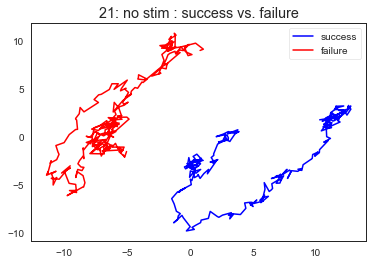

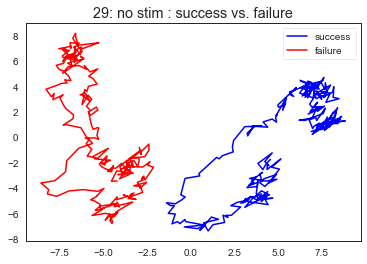

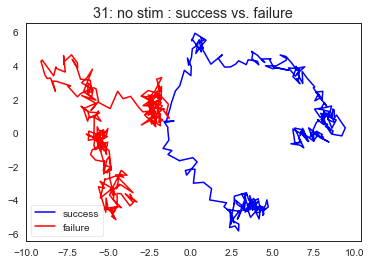

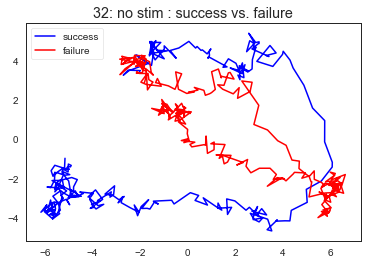

In [173]:
x = df_pcs_all[df_pcs_all.stim=='nostim'].traj_sf
y = df_pcs_all[df_pcs_all.stim=='nostim'].traj_sf
x_ = df_pcs_all[df_pcs_all.stim=='nostim'].traj_sf
y_ = df_pcs_all[df_pcs_all.stim=='nostim'].traj_sf
m = df_pcs_all[df_pcs_all.stim=='nostim'].mouse
for i,trajs in enumerate(x):
    plt.figure()
    plt.plot(x[i][0][:270],y[i][1][:270],'b')
    plt.plot(x_[i][0][270:],y_[i][1][270:],'r')
    mouse = m[i]
    title = mouse +str(': no stim : success vs. failure')
    plt.title(title)
    g = 'success','failure'
    plt.legend(g)
    plt.show()
    plt.close()
    save_path = '/Users/kimberlygagnon/Documents/CU/Welle Lab/experiments/xiaoyu/figs/succvs.fail/21/Day10/'
    #plt.savefig(save_path+str(title)+'.png', format="PNG") #CHANGE MOUSE NUMBER BEFORE RUNNING      

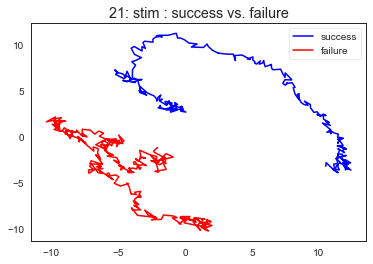

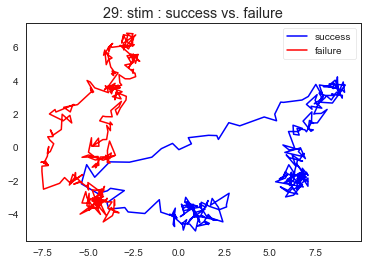

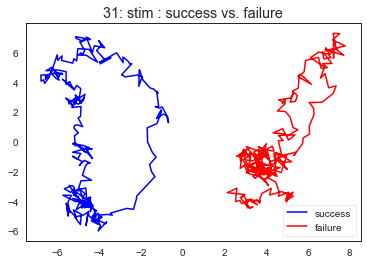

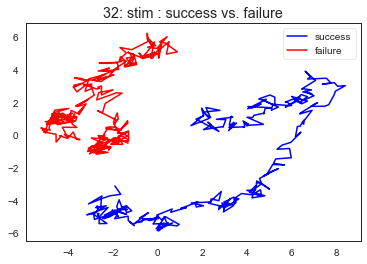

In [175]:
x = df_pcs_all[df_pcs_all.stim=='stim'].traj_sf
y = df_pcs_all[df_pcs_all.stim=='stim'].traj_sf
x_ = df_pcs_all[df_pcs_all.stim=='stim'].traj_sf
y_ = df_pcs_all[df_pcs_all.stim=='stim'].traj_sf
m = df_pcs_all[df_pcs_all.stim=='stim'].mouse
for i,trajs in enumerate(x):
    plt.figure()
    plt.plot(x[i][0][:270],y[i][1][:270],'b')
    plt.plot(x_[i][0][270:],y_[i][1][270:],'r')
    mouse = m[i]
    title = mouse +str(': stim : success vs. failure')
    plt.title(title)
    g = 'success','failure'
    plt.legend(g)
    plt.show()
    plt.close()
    save_path = '/Users/kimberlygagnon/Documents/CU/Welle Lab/experiments/xiaoyu/figs/succvs.fail/21/Day10/'
    #plt.savefig(save_path+str(title)+'.png', format="PNG") #CHANGE MOUSE NUMBER BEFORE RUNNING      

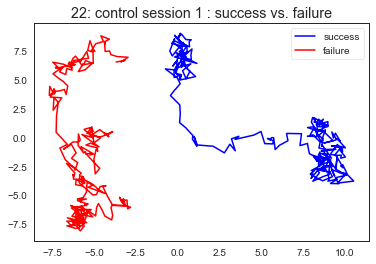

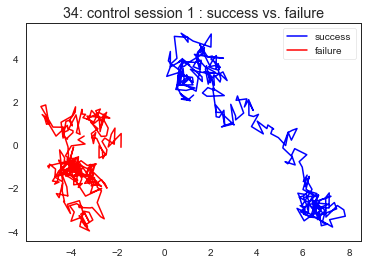

In [176]:
x = df_pcs_all[df_pcs_all.stim=='cs1'].traj_sf
y = df_pcs_all[df_pcs_all.stim=='cs1'].traj_sf
x_ = df_pcs_all[df_pcs_all.stim=='cs1'].traj_sf
y_ = df_pcs_all[df_pcs_all.stim=='cs1'].traj_sf
m = df_pcs_all[df_pcs_all.stim=='cs1'].mouse
for i,trajs in enumerate(x):
    plt.figure()
    plt.plot(x[i][0][:270],y[i][1][:270],'b')
    plt.plot(x_[i][0][270:],y_[i][1][270:],'r')
    mouse = m[i]
    title = mouse +str(': control session 1 : success vs. failure')
    plt.title(title)
    g = 'success','failure'
    plt.legend(g)
    plt.show()
    plt.close()
    save_path = '/Users/kimberlygagnon/Documents/CU/Welle Lab/experiments/xiaoyu/figs/succvs.fail/21/Day10/'
    #plt.savefig(save_path+str(title)+'.png', format="PNG") #CHANGE MOUSE NUMBER BEFORE RUNNING      

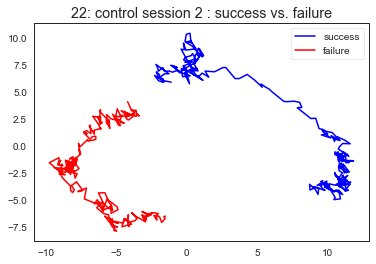

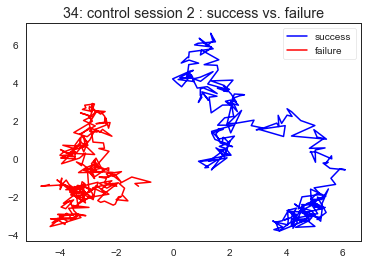

In [177]:
x = df_pcs_all[df_pcs_all.stim=='cs2'].traj_sf
y = df_pcs_all[df_pcs_all.stim=='cs2'].traj_sf
x_ = df_pcs_all[df_pcs_all.stim=='cs2'].traj_sf
y_ = df_pcs_all[df_pcs_all.stim=='cs2'].traj_sf
m = df_pcs_all[df_pcs_all.stim=='cs2'].mouse
for i,trajs in enumerate(x):
    plt.figure()
    plt.plot(x[i][0][:270],y[i][1][:270],'b')
    plt.plot(x_[i][0][270:],y_[i][1][270:],'r')
    mouse = m[i]
    title = mouse +str(': control session 2 : success vs. failure')
    plt.title(title)
    g = 'success','failure'
    plt.legend(g)
    plt.show()
    plt.close()
    save_path = '/Users/kimberlygagnon/Documents/CU/Welle Lab/experiments/xiaoyu/figs/succvs.fail/21/Day10/'
    #plt.savefig(save_path+str(title)+'.png', format="PNG") #CHANGE MOUSE NUMBER BEFORE RUNNING      

# 3D PC

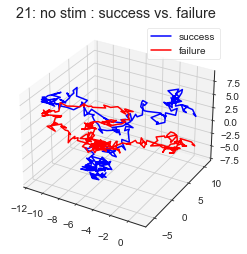

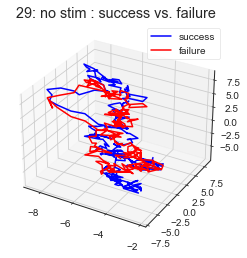

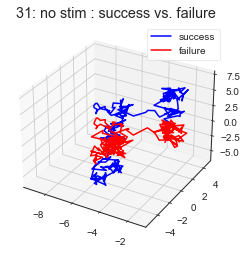

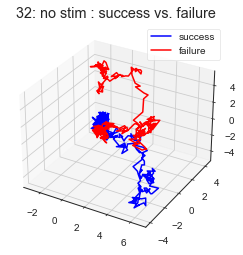

In [179]:
x = df_pcs_all[df_pcs_all.stim=='nostim'].traj_sf
y = df_pcs_all[df_pcs_all.stim=='nostim'].traj_sf
z = df_pcs_all[df_pcs_all.stim=='nostim'].traj_sf
x_ = df_pcs_all[df_pcs_all.stim=='nostim'].traj_sf
y_ = df_pcs_all[df_pcs_all.stim=='nostim'].traj_sf
z_ = df_pcs_all[df_pcs_all.stim=='nostim'].traj_sf
m = df_pcs_all[df_pcs_all.stim=='nostim'].mouse
for i,trajs in enumerate(x):
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.plot3D(x[i][0][270:],y[i][1][270:],z[i][2][270:],'b')
    ax.plot3D(x_[i][0][270:],y_[i][1][270:],z[i][2][:270],'r')
    mouse = m[i]
    title = mouse +str(': no stim : success vs. failure')
    plt.title(title)
    g = 'success','failure'
    plt.legend(g)
    plt.show()
    plt.close()
    save_path = '/Users/kimberlygagnon/Documents/CU/Welle Lab/experiments/xiaoyu/figs/succvs.fail/21/Day10/'
    #plt.savefig(save_path+str(title)+str('3D')+'.png', format="PNG") #CHANGE MOUSE NUMBER BEFORE RUNNING

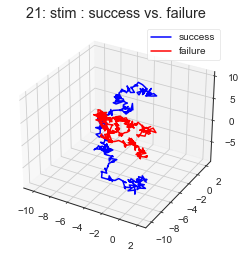

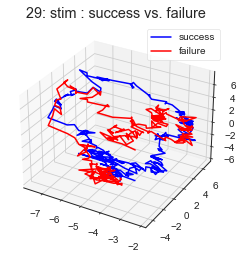

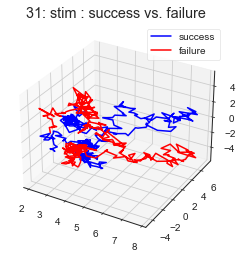

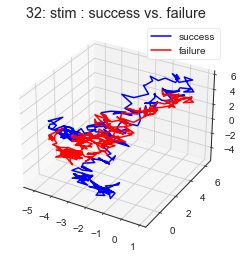

In [181]:
x = df_pcs_all[df_pcs_all.stim=='stim'].traj_sf
y = df_pcs_all[df_pcs_all.stim=='stim'].traj_sf
z = df_pcs_all[df_pcs_all.stim=='stim'].traj_sf
x_ = df_pcs_all[df_pcs_all.stim=='stim'].traj_sf
y_ = df_pcs_all[df_pcs_all.stim=='stim'].traj_sf
z_ = df_pcs_all[df_pcs_all.stim=='stim'].traj_sf
m = df_pcs_all[df_pcs_all.stim=='stim'].mouse
for i,trajs in enumerate(x):
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.plot3D(x[i][0][270:],y[i][1][270:],z[i][2][270:],'b')
    ax.plot3D(x_[i][0][270:],y_[i][1][270:],z[i][2][:270],'r')
    mouse = m[i]
    title = mouse +str(': stim : success vs. failure')
    plt.title(title)
    g = 'success','failure'
    plt.legend(g)
    plt.show()
    plt.close()
    save_path = '/Users/kimberlygagnon/Documents/CU/Welle Lab/experiments/xiaoyu/figs/succvs.fail/21/Day10/'
    #plt.savefig(save_path+str(title)+str('3D')+'.png', format="PNG") #CHANGE MOUSE NUMBER BEFORE RUNNING

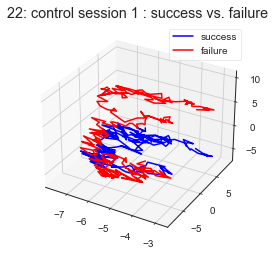

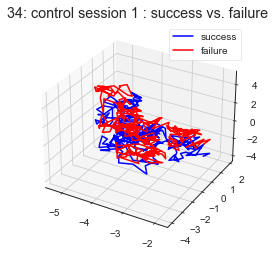

In [183]:
x = df_pcs_all[df_pcs_all.stim=='cs1'].traj_sf
y = df_pcs_all[df_pcs_all.stim=='cs1'].traj_sf
z = df_pcs_all[df_pcs_all.stim=='cs1'].traj_sf
x_ = df_pcs_all[df_pcs_all.stim=='cs1'].traj_sf
y_ = df_pcs_all[df_pcs_all.stim=='cs1'].traj_sf
z_ = df_pcs_all[df_pcs_all.stim=='cs1'].traj_sf
m = df_pcs_all[df_pcs_all.stim=='cs1'].mouse
for i,trajs in enumerate(x):
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.plot3D(x[i][0][270:],y[i][1][270:],z[i][2][270:],'b')
    ax.plot3D(x_[i][0][270:],y_[i][1][270:],z[i][2][:270],'r')
    mouse = m[i]
    title = mouse +str(': control session 1 : success vs. failure')
    plt.title(title)
    g = 'success','failure'
    plt.legend(g)
    plt.show()
    plt.close()
    save_path = '/Users/kimberlygagnon/Documents/CU/Welle Lab/experiments/xiaoyu/figs/succvs.fail/21/Day10/'
    #plt.savefig(save_path+str(title)+str('3D')+'.png', format="PNG") #CHANGE MOUSE NUMBER BEFORE RUNNING

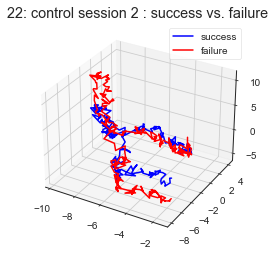

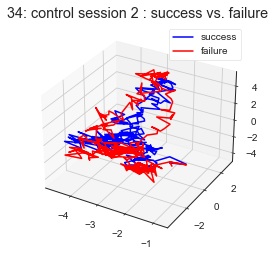

In [185]:
x = df_pcs_all[df_pcs_all.stim=='cs2'].traj_sf
y = df_pcs_all[df_pcs_all.stim=='cs2'].traj_sf
z = df_pcs_all[df_pcs_all.stim=='cs2'].traj_sf
x_ = df_pcs_all[df_pcs_all.stim=='cs2'].traj_sf
y_ = df_pcs_all[df_pcs_all.stim=='cs2'].traj_sf
z_ = df_pcs_all[df_pcs_all.stim=='cs2'].traj_sf
m = df_pcs_all[df_pcs_all.stim=='cs2'].mouse
for i,trajs in enumerate(x):
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.plot3D(x[i][0][270:],y[i][1][270:],z[i][2][270:],'b')
    ax.plot3D(x_[i][0][270:],y_[i][1][270:],z[i][2][:270],'r')
    mouse = m[i]
    title = mouse +str(': control session 2 : success vs. failure')
    plt.title(title)
    g = 'success','failure'
    plt.legend(g)
    plt.show()
    plt.close()
    save_path = '/Users/kimberlygagnon/Documents/CU/Welle Lab/experiments/xiaoyu/figs/succvs.fail/21/Day10/'
    #plt.savefig(save_path+str(title)+str('3D')+'.png', format="PNG") #CHANGE MOUSE NUMBER BEFORE RUNNING

# time Vs. PCs

In [206]:
df_pcs_all

,index,mouse,ave_bins,normedbins,maxdf_bins,mindf_bins,ave_bins_f,normedbins_f,maxdf_bins_f,mindf_bins_f,traj_sf,ev_sf,stim
0,0,21,"[[0.3803139717837578, 0.38334365313998486, 0.3...","[[0.44878550652860255, 0.4565720981459694, 0.4...","[19, 111, 249, 34, 66, 123, 141, 156, 111, 183...","[233, 176, 132, 186, 267, 45, 16, 4, 63, 98, 7...","[[0.29937089106689985, 0.3015274240771063, 0.3...","[[0.11701480951969326, 0.12121438009635188, 0....","[140, 127, 265, 156, 26, 129, 3, 1, 13, 219, 2...","[82, 193, 43, 103, 243, 6, 257, 118, 165, 6, 2...","[[3.0251735581234227, 3.048361587469502, 2.952...","[0.27233818576524793, 0.1102305254359521, 0.09...",nostim
1,1,29,"[[0.2952989032262768, 0.28099202616877195, 0.2...","[[0.19131562484166706, 0.1531387957642667, 0.0...","[143, 139, 140, 242, 7, 167, 92, 192, 53, 243,...","[28, 224, 87, 91, 221, 20, 237, 266, 87, 94, 2...","[[0.37424137222625503, 0.3583733507439967, 0.3...","[[0.1792381732891155, 0.14080650509496342, 0.1...","[18, 152, 27, 69, 223, 21, 105, 122, 27, 155, ...","[90, 13, 148, 185, 94, 102, 55, 82, 91, 107, 2...","[[4.557034951554958, 4.503349820982335, 4.2583...","[0.28490271692299707, 0.14518652517131894, 0.1...",nostim
2,2,31,"[[0.2320691847332922, 0.24285118121611088, 0.2...","[[0.07809904310259062, 0.1072376740032709, 0.0...","[193, 120, 234, 102, 118, 155, 170, 263, 128, ...","[114, 269, 127, 200, 260, 121, 62, 97, 15, 102...","[[0.17989239257077475, 0.18121827015176872, 0....","[[0.16323527068435945, 0.1684083251759971, 0.1...","[99, 192, 25, 99, 110, 123, 221, 119, 98, 129,...","[36, 113, 246, 265, 216, 43, 58, 1, 224, 257, ...","[[3.442706162923287, 3.109298287424546, 3.4387...","[0.31178535703750615, 0.10597545584951878, 0.0...",nostim
3,3,32,"[[0.1678193708292619, 0.16700906461969697, 0.1...","[[0.03643125874782476, 0.034817675243781564, 0...","[114, 63, 53, 143, 127, 109, 9, 97, 203, 261, ...","[9, 251, 227, 99, 262, 23, 95, 73, 26, 86, 24,...","[[0.28327254676502067, 0.2670167378726153, 0.2...","[[0.17134703497325277, 0.12988242375459383, 0....","[198, 171, 194, 169, 170, 107, 6, 106, 56, 35,...","[47, 32, 87, 109, 29, 223, 153, 77, 209, 135, ...","[[-2.0165914185766325, -1.989177288574167, -2....","[0.23179092350047764, 0.1621163726242971, 0.13...",nostim
4,0,21,"[[0.4754088970472403, 0.4827885532384724, 0.49...","[[0.30035109123432197, 0.3153231513178391, 0.3...","[4, 249, 230, 121, 44, 2, 7, 252, 103, 105, 2,...","[239, 93, 40, 2, 189, 97, 82, 47, 263, 80, 173...","[[0.476725559469744, 0.495445030485356, 0.4599...","[[0.13961565438627577, 0.17207733207962292, 0....","[198, 146, 67, 83, 268, 28, 250, 31, 138, 247,...","[129, 4, 167, 262, 106, 150, 113, 267, 41, 62,...","[[-1.5665162212436827, -2.009242232558877, -1....","[0.2181988556172051, 0.13309131657865264, 0.11...",stim
5,1,29,"[[0.2534033242641035, 0.24903228817344067, 0.2...","[[0.051233680757774125, 0.043600655420855276, ...","[231, 130, 121, 231, 54, 92, 109, 142, 211, 17...","[9, 231, 70, 93, 92, 191, 164, 96, 93, 93, 244...","[[0.3694840877386772, 0.3653914906219051, 0.36...","[[0.43116747636855574, 0.4200909584545648, 0.4...","[0, 0, 145, 200, 40, 110, 37, 73, 58, 73, 268,...","[267, 88, 86, 18, 162, 221, 211, 4, 220, 100, ...","[[1.6277604931743734, 1.3770433348785003, 1.01...","[0.3259441649583287, 0.13413244822227122, 0.11...",stim
6,2,31,"[[0.29988614817588183, 0.310252399704709, 0.31...","[[0.1270034996413766, 0.15677211862746618, 0.1...","[231, 132, 68, 135, 85, 45, 96, 147, 6, 82, 7,...","[125, 245, 184, 73, 212, 269, 269, 33, 139, 26...","[[0.40463115848057246, 0.40283121116940795, 0....","[[0.1676367639589285, 0.16368701388340698, 0.1...","[240, 108, 85, 117, 241, 99, 156, 71, 240, 183...","[172, 243, 244, 234, 54, 254, 2, 238, 68, 55, ...","[[-4.398392153995471, -4.432465282317759, -4.4...","[0.2848440950362339, 0.17315173401595454, 0.09...",stim
7,3,32,"[[0.28901712200324225, 0.29357405108324736, 0....","[[0.2460247891957097, 0.2605062031282132, 0.22...","[107, 35, 60, 35, 81, 60, 103, 1

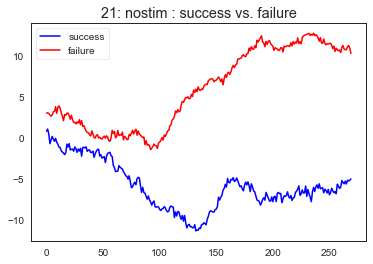

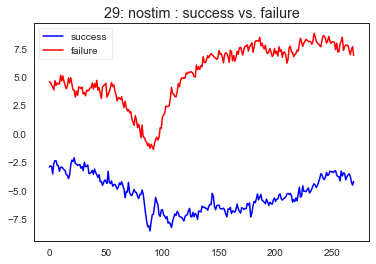

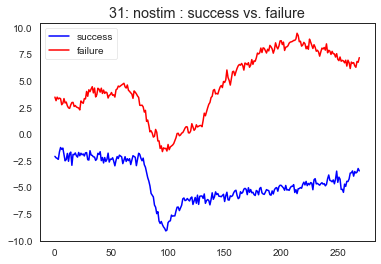

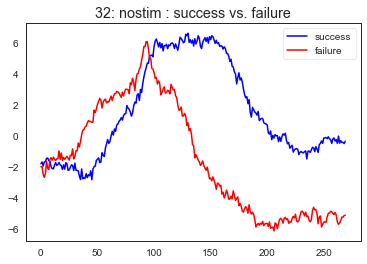

In [211]:
x = df_pcs_all[df_pcs_all.stim=='nostim'].traj_sf
y = df_pcs_all[df_pcs_all.stim=='stim'].traj_sf
m = df_pcs_all[df_pcs_all.stim=='nostim'].mouse

#y = (df_pcs_all[df_pcs_all.stim=='nostim'].reset_index()).traj_sf
#z = (df_pcs_all[df_pcs_all.stim=='nostim'].reset_index()).traj_sf
#x_ = (df_pcs_all[df_pcs_all.stim=='nostim'].reset_index()).traj_sf
for i,trajs in enumerate(x):
    fig = plt.figure()
    plt.plot(x[i][0][270:],'b')
    plt.plot(y[i][0][270:])
    plt.plot(x[i][0][:270],'r')
    #plt.plot(z_[i][0][:270],'r')
    mouse = m[i]
    title = mouse +str(': nostim : success vs. failure')
    plt.title(title)
    g = 'success','failure'
    plt.legend(g)
    plt.show()
    plt.close()
    save_path = '/Users/kimberlygagnon/Documents/CU/Welle Lab/experiments/xiaoyu/figs/succvs.fail/21/Day10/'
    #plt.savefig(save_path+str(title)+str('3D')+'.png', format="PNG") #CHANGE MOUSE NUMBER BEFORE RUNNING

In [218]:
df_pcs_all[df_pcs_all.stim=='stim'].mouse

4    21
5    29
6    31
7    32
Name: mouse, dtype: object

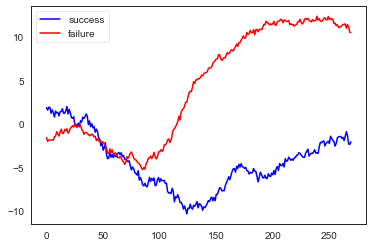

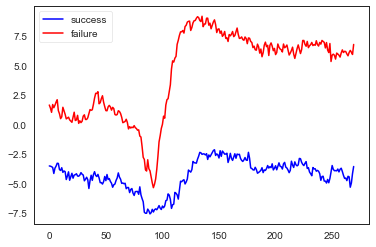

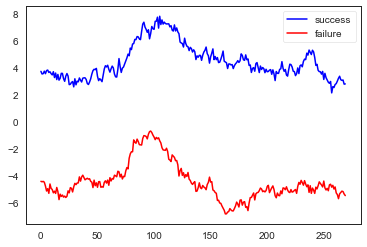

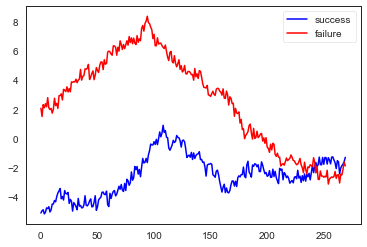

In [219]:
b

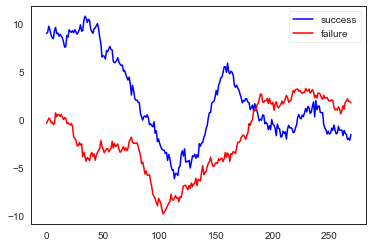

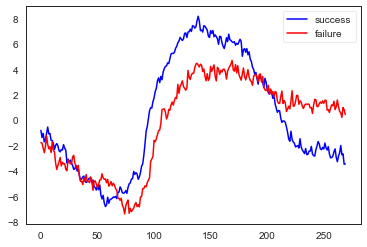

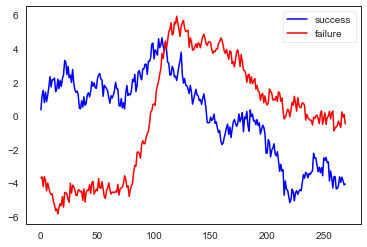

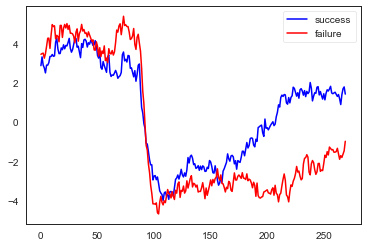

In [227]:
x = df_pcs_all[df_pcs_all.stim=='nostim'].traj_sf
#m = df_pcs_all[df_pcs_all.stim=='nostim'].mouse

#y = (df_pcs_all[df_pcs_all.stim=='nostim'].reset_index()).traj_sf
#z = (df_pcs_all[df_pcs_all.stim=='nostim'].reset_index()).traj_sf
#x_ = (df_pcs_all[df_pcs_all.stim=='nostim'].reset_index()).traj_sf
for i,trajs in enumerate(x):
    fig = plt.figure()
    plt.plot(trajs[1][270:],'b')
    plt.plot(trajs[1][:270],'r')
    #plt.plot(z_[i][0][:270],'r')
    #mouse = m[i]
    #title = mouse +str(': control session 2 : success vs. failure')
    #plt.title(title)
    g = 'success','failure'
    plt.legend(g)
    plt.show()
    plt.close()
    save_path = '/Users/kimberlygagnon/Documents/CU/Welle Lab/experiments/xiaoyu/figs/succvs.fail/21/Day10/'
    #plt.savefig(save_path+str(title)+str('3D')+'.png', format="PNG") #CHANGE MOUSE NUMBER BEFORE RUNNING

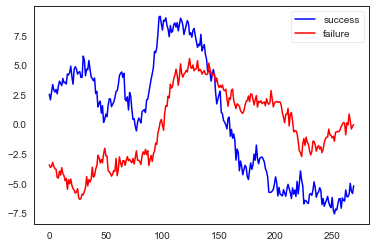

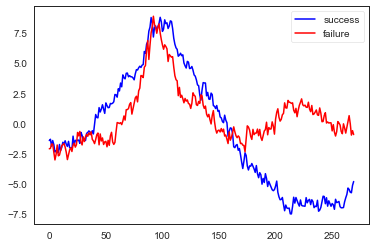

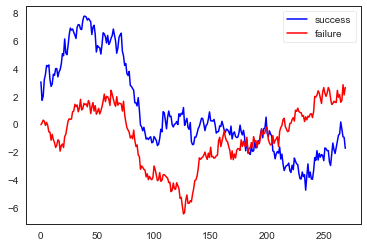

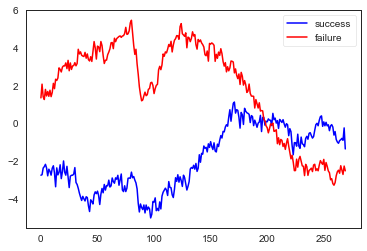

In [228]:
x = df_pcs_all[df_pcs_all.stim=='nostim'].traj_sf
#m = df_pcs_all[df_pcs_all.stim=='nostim'].mouse

#y = (df_pcs_all[df_pcs_all.stim=='nostim'].reset_index()).traj_sf
#z = (df_pcs_all[df_pcs_all.stim=='nostim'].reset_index()).traj_sf
#x_ = (df_pcs_all[df_pcs_all.stim=='nostim'].reset_index()).traj_sf
for i,trajs in enumerate(x):
    fig = plt.figure()
    plt.plot(trajs[2][270:],'b')
    plt.plot(trajs[2][:270],'r')
    #plt.plot(z_[i][0][:270],'r')
    #mouse = m[i]
    #title = mouse +str(': control session 2 : success vs. failure')
    #plt.title(title)
    g = 'success','failure'
    plt.legend(g)
    plt.show()
    plt.close()
    save_path = '/Users/kimberlygagnon/Documents/CU/Welle Lab/experiments/xiaoyu/figs/succvs.fail/21/Day10/'
    #plt.savefig(save_path+str(title)+str('3D')+'.png', format="PNG") #CHANGE MOUSE NUMBER BEFORE RUNNING

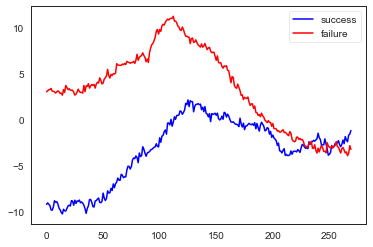

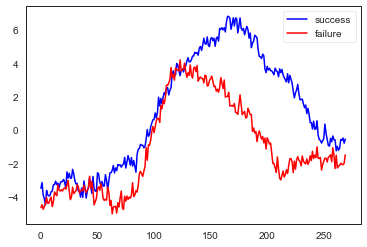

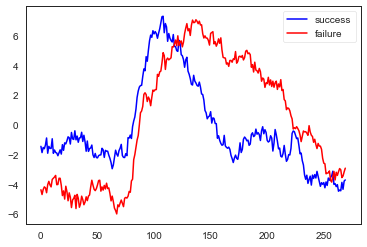

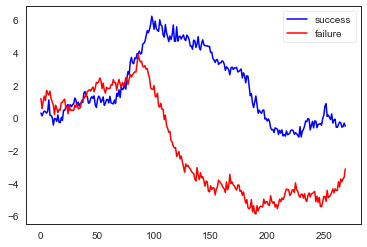

In [229]:
x = df_pcs_all[df_pcs_all.stim=='stim'].traj_sf
#m = df_pcs_all[df_pcs_all.stim=='nostim'].mouse

#y = (df_pcs_all[df_pcs_all.stim=='nostim'].reset_index()).traj_sf
#z = (df_pcs_all[df_pcs_all.stim=='nostim'].reset_index()).traj_sf
#x_ = (df_pcs_all[df_pcs_all.stim=='nostim'].reset_index()).traj_sf
for i,trajs in enumerate(x):
    fig = plt.figure()
    plt.plot(trajs[1][270:],'b')
    plt.plot(trajs[1][:270],'r')
    #plt.plot(z_[i][0][:270],'r')
    #mouse = m[i]
    #title = mouse +str(': control session 2 : success vs. failure')
    #plt.title(title)
    g = 'success','failure'
    plt.legend(g)
    plt.show()
    plt.close()
    save_path = '/Users/kimberlygagnon/Documents/CU/Welle Lab/experiments/xiaoyu/figs/succvs.fail/21/Day10/'
    #plt.savefig(save_path+str(title)+str('3D')+'.png', format="PNG") #CHANGE MOUSE NUMBER BEFORE RUNNING

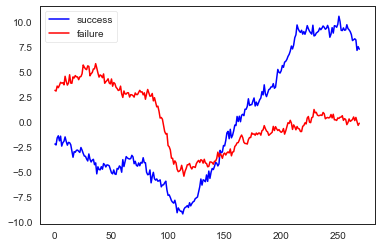

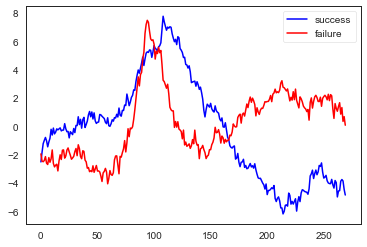

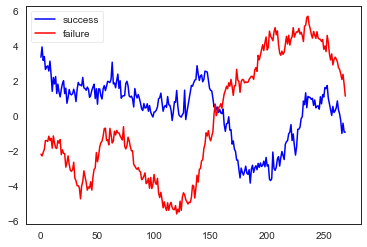

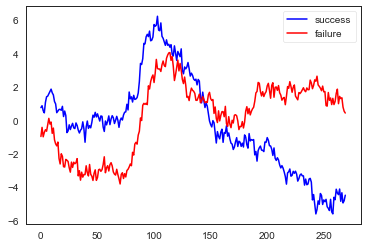

In [230]:
x = df_pcs_all[df_pcs_all.stim=='stim'].traj_sf
#m = df_pcs_all[df_pcs_all.stim=='nostim'].mouse

#y = (df_pcs_all[df_pcs_all.stim=='nostim'].reset_index()).traj_sf
#z = (df_pcs_all[df_pcs_all.stim=='nostim'].reset_index()).traj_sf
#x_ = (df_pcs_all[df_pcs_all.stim=='nostim'].reset_index()).traj_sf
for i,trajs in enumerate(x):
    fig = plt.figure()
    plt.plot(trajs[2][270:],'b')
    plt.plot(trajs[2][:270],'r')
    #plt.plot(z_[i][0][:270],'r')
    #mouse = m[i]
    #title = mouse +str(': control session 2 : success vs. failure')
    #plt.title(title)
    g = 'success','failure'
    plt.legend(g)
    plt.show()
    plt.close()
    save_path = '/Users/kimberlygagnon/Documents/CU/Welle Lab/experiments/xiaoyu/figs/succvs.fail/21/Day10/'
    #plt.savefig(save_path+str(title)+str('3D')+'.png', format="PNG") #CHANGE MOUSE NUMBER BEFORE RUNNING

# heatmap

In [190]:
df_pcs_all = df_pcs_all.reset_index()

In [192]:
df_pcs = df_pcs_all[df_pcs_all.stim=='nostim']

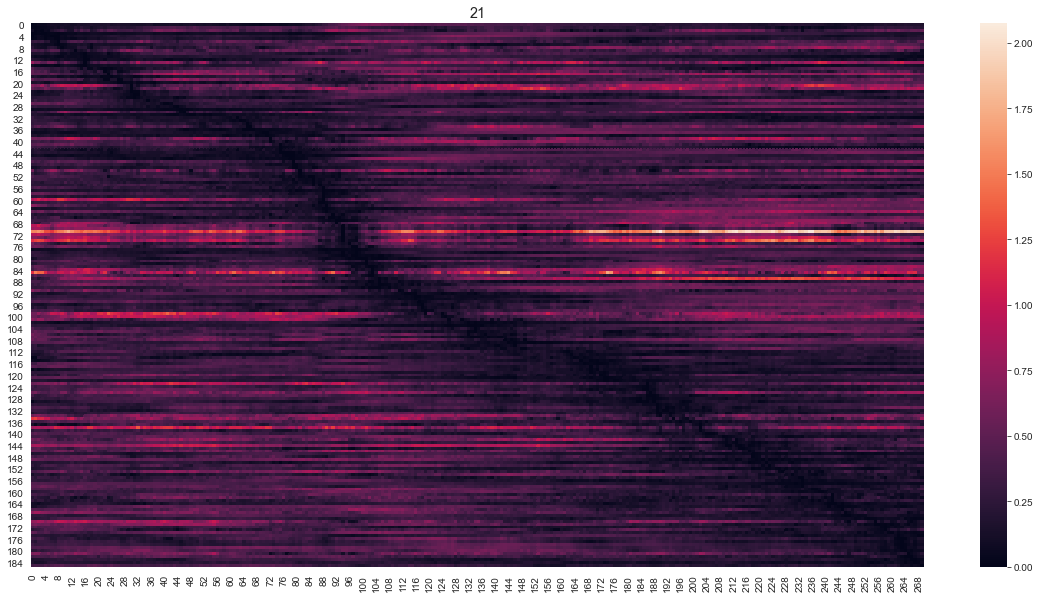

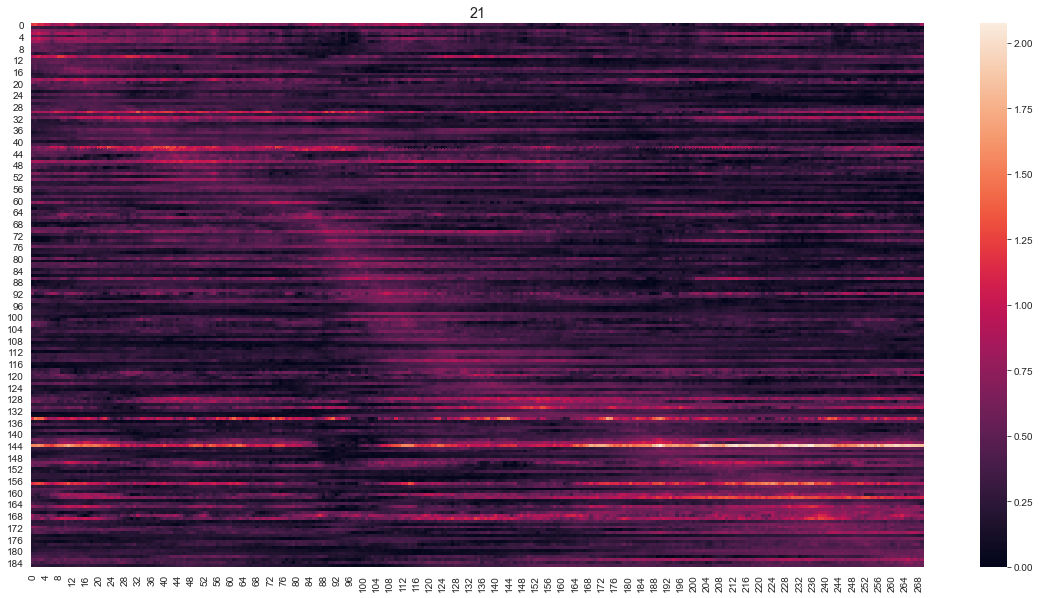

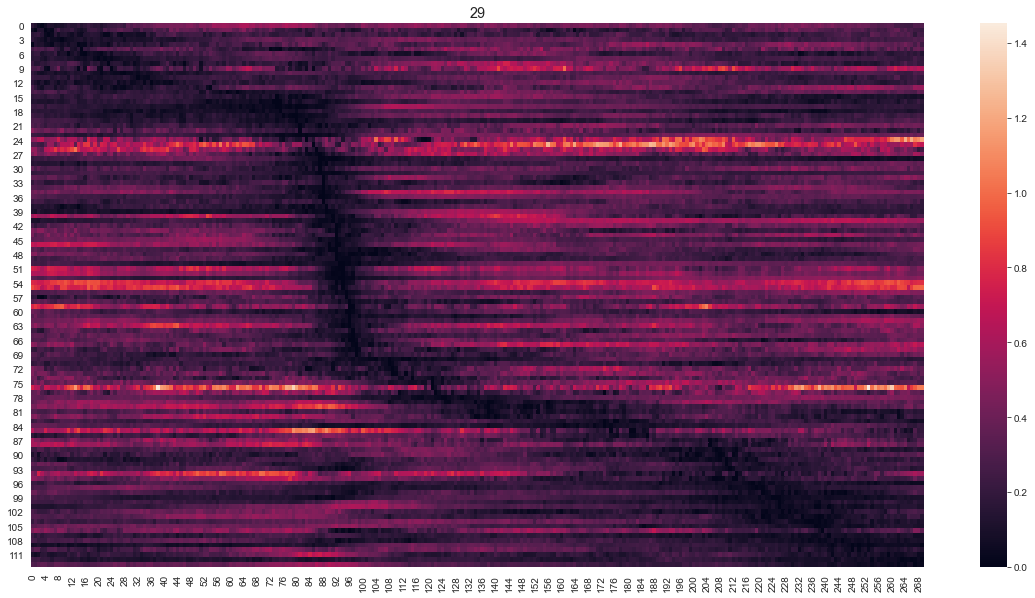

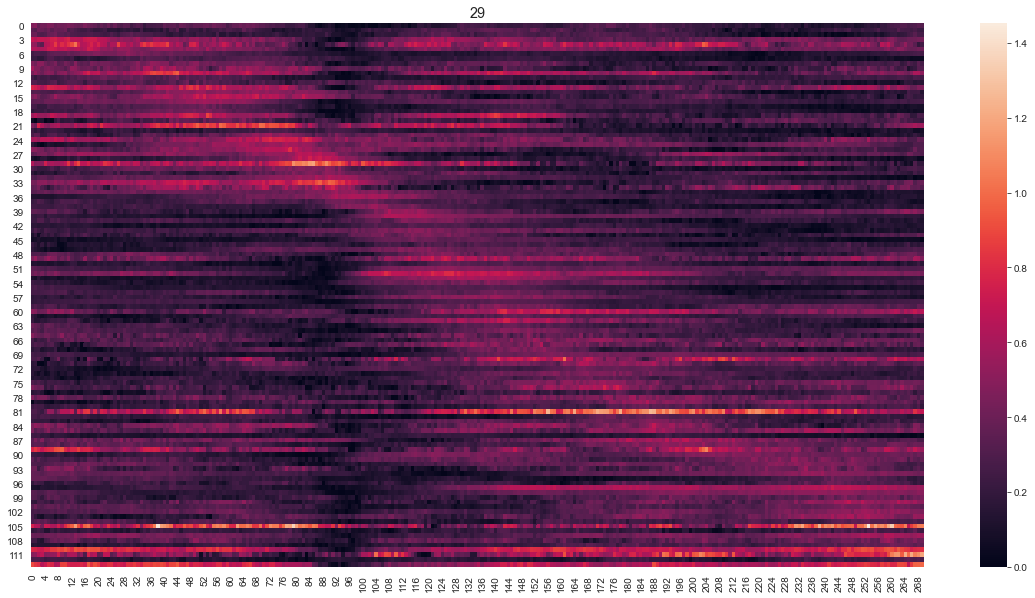

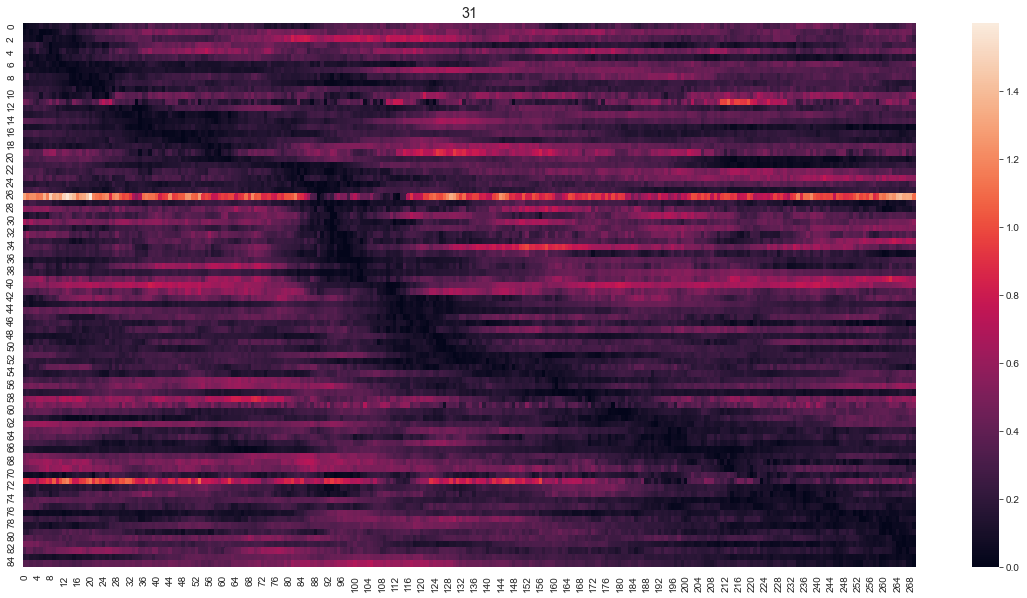

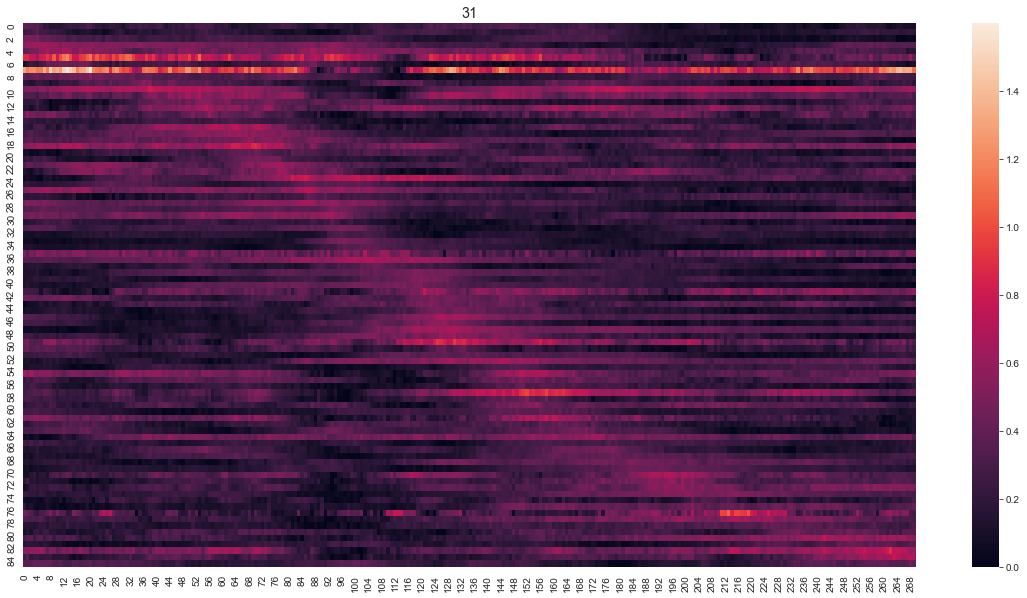

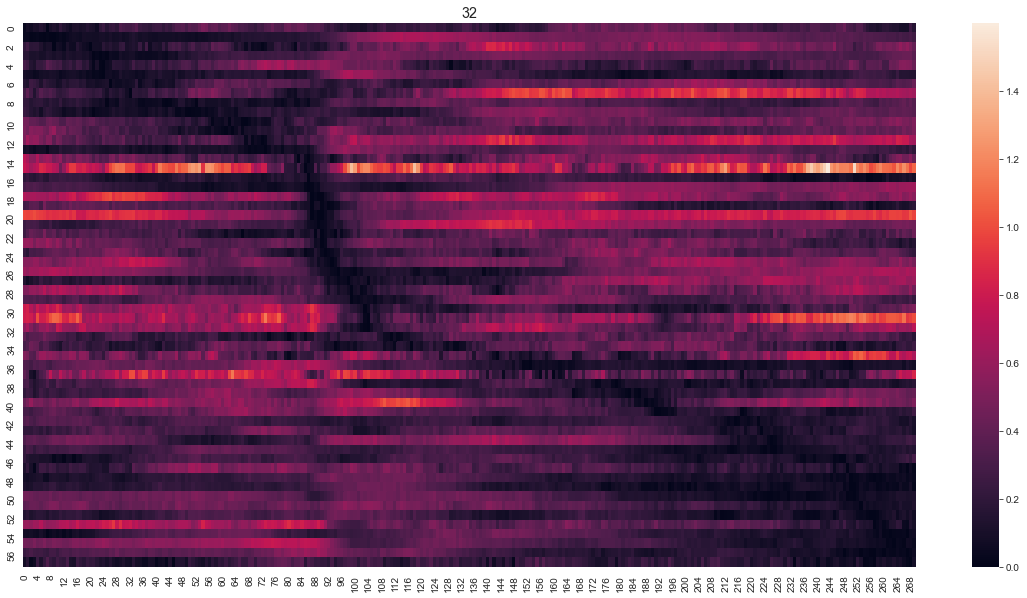

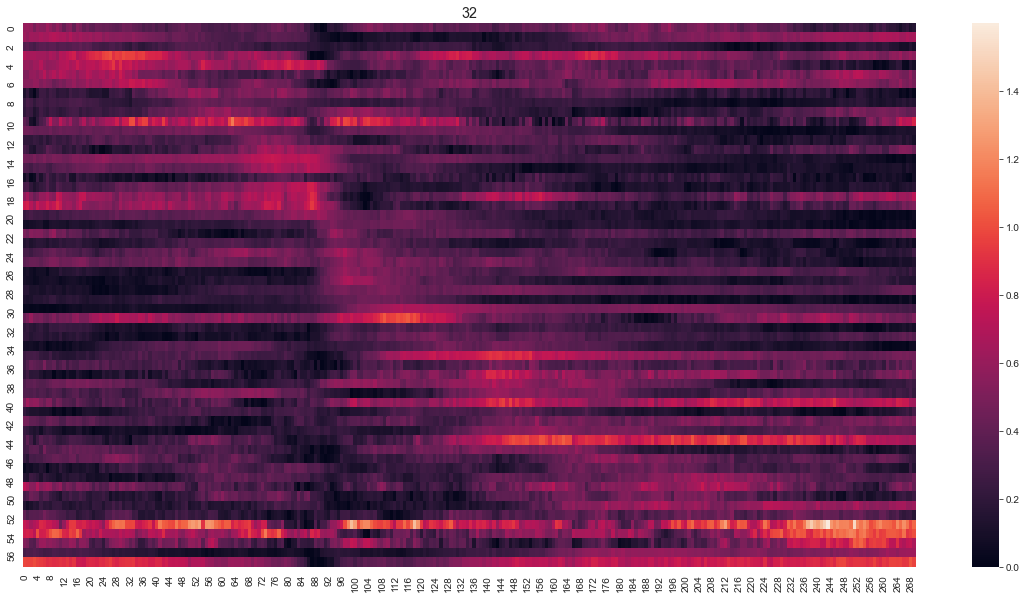

In [193]:
df_ = df_pcs
for i,permouse in enumerate(df_.normedbins):
    mouse = df_.mouse[i]
    start = '90'
    end = '600'
    a = df_.maxdf_bins[i]
    b = df_.mindf_bins[i]
    c = permouse
    d = np.shape(permouse)[0]
    
    min_bin = np.zeros((d,1))
    for i,tbins in enumerate(b):
        min_bin[i,:] = b[i]
        
    max_bin = np.zeros((d,1))
    for i,tbins in enumerate(a):
        max_bin[i,:] = a[i]

    hmap = []
    for i,bins in enumerate(c):
        hmap.append(bins)
    
    df_temp = pd.DataFrame(data=max_bin,columns=['tmax'])
    df_temp['tmin'] = min_bin
    df_temp['normedbins'] = hmap
    
    df_s = df_temp.sort_values(by=['tmin'])
    df_bins = df_s.normedbins
    df_heatmap = list(filter(any, df_bins))
    fig, ax = plt.subplots(figsize=(20, 10))
    sns.heatmap(df_heatmap)
    plt.title(mouse)
    plt.show()
    save_path = '/Users/kimberlygagnon/Documents/CU/Welle Lab/experiments/xiaoyu/figs/cs1cs2_reran/'
    #fig.savefig(save_path+str(mouse)+'_cs1_downmod_'+str('_') +str(i)+str('_') +str(start)+str('_') +str(end)+'.png')
    plt.close()
    
    df_s = df_temp.sort_values(by=['tmax'])
    df_bins = df_s.normedbins
    df_heatmap = list(filter(any, df_bins))
    fig, ax = plt.subplots(figsize=(20, 10))
    sns.heatmap(df_heatmap)
    plt.title(mouse)
    save_path = '/Users/kimberlygagnon/Documents/CU/Welle Lab/experiments/xiaoyu/figs/cs1cs2_reran/'
    #fig.savefig(save_path+str(mouse)+'_cs1_upmod_'+str('_') +str(i)+str('_') +str(start)+str('_') +str(end)+'.png')
    plt.show()
    plt.close()